# House Prices: Advanced Regression Techniques
Predict sales prices and practice feature engineering, RFs, and gradient boosting

## 1. Load and explore data

In [1]:
# Upload dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


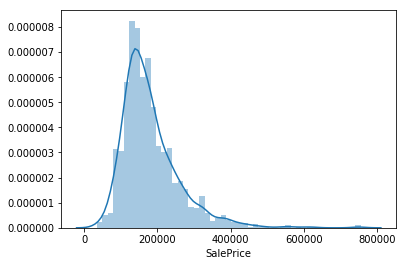

In [2]:
sns.distplot(train['SalePrice'])

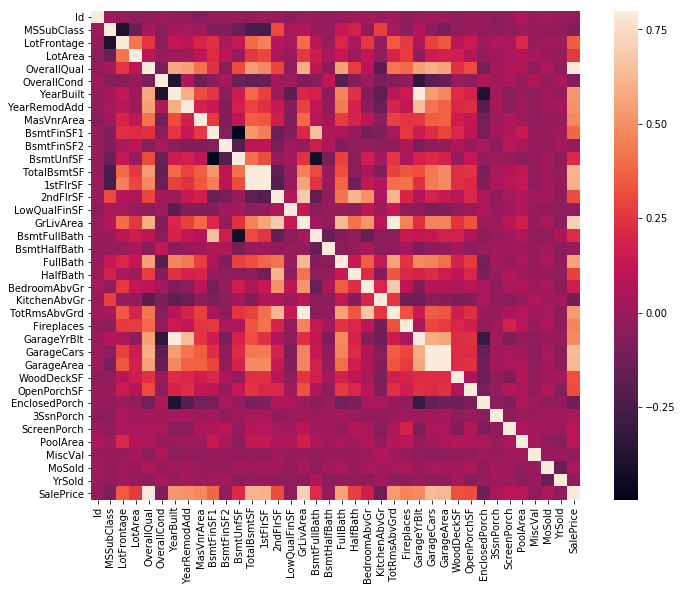

In [3]:
corr_mat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, vmax=.8, square=True)

## 2. Prepare Data

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

def plot_scatter(data):
    fig, axes = plt.subplots(1,len(data.columns.values)-1, sharey=True, figsize=(21, 3))
    for i, col in enumerate(data.columns.values[:-1]):
        data.plot(x=col, y="SalePrice", kind="scatter", ax=axes[i])

def plot_boxplot(cat, data, ordered=False):
    f, ax = plt.subplots(1, len(cat), sharey=True, figsize=(21, 4))
    for i, var in enumerate(cat):
        ord=None
        if ordered:
            ord = data.groupby(var)["SalePrice"].median().fillna(0).sort_values(ascending=False)[::-1].index
        d = pd.concat([data['SalePrice'], data[var]], axis=1)
        sns.boxplot(x=var, y="SalePrice", data=d, ax=ax[i], order=ord, showfliers=False)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

### 2.0 Features with Missing Values

In [6]:
class MissingValuesAttributeRemove(BaseEstimator, TransformerMixin):
    def fit(self, data):
        return self
    def transform(self, data):
        remove_attribute = [
            "Alley",       # Drop Alley (>93% features missing)
            "FireplaceQu", # Drop FireplaceQu (>47% features missing)
            "PoolQC",      # Drop PollQC (>99% features missing)
            "Fence",       # Drop Fence (>80% features missing)
            "MiscFeature", # Drop MiscFeature (>96% features missing)
            "MiscVal",     # Drop MiscVal (value of MiscFeature)
        ]
        for attribute in remove_attribute:
            data = data.drop(attribute, axis=1)
        return data

### 2.1 Quality Features
* Convert categorical features to ordinal features
* Might be worth removing Garage Quality
* Might be worth using only Overall Quality

In [7]:
class QualityAttributeTransformTemp(BaseEstimator, TransformerMixin):
    def fit(self, data):
        return self
    def transform(self, data):
        data = data.dropna(subset=['BsmtQual', 'GarageQual'])
        attribute_grade = ['ExterQual', 'BsmtQual', 'KitchenQual', 'GarageQual']
        encoder = OrdinalEncoder(categories = [['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])
        for attribute in attribute_grade:
            data[[attribute]] = encoder.fit_transform(data[[attribute]])
        return data

In [8]:
quality_pipeline = Pipeline([
    ("quality_attribute_transformer", QualityAttributeTransformTemp()),
])
train_quality = quality_pipeline.fit_transform(train)
train_quality = train_quality[['OverallQual', 'ExterQual', 'BsmtQual', 'KitchenQual', 'GarageQual', 'SalePrice']]

# Correlations matrix
corr_matrix = train_quality.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice      1.000000
OverallQual    0.784687
ExterQual      0.671003
KitchenQual    0.651205
BsmtQual       0.644308
GarageQual     0.160532
Name: SalePrice, dtype: float64

In [9]:
# Correlations matrix
corr_matrix = train_quality.corr()
corr_matrix["OverallQual"].sort_values(ascending=False)

OverallQual    1.000000
SalePrice      0.784687
ExterQual      0.724748
BsmtQual       0.673775
KitchenQual    0.668821
GarageQual     0.150718
Name: OverallQual, dtype: float64

In [10]:
class QualityAttributeTransform(BaseEstimator, TransformerMixin):
    def fit(self, data):
        return self
    def transform(self, data):
        remove_attribute = ['ExterQual', 'BsmtQual', 'KitchenQual', 'GarageQual']
        for attribute in remove_attribute:
            data = data.drop(attribute, axis=1)
        return data

### 2.2 Condition Features
* Convert categorical features to ordinal features
* Weak correlation with Sale Price
* Drop features

In [11]:
class ConditionAttributeTransformTemp(BaseEstimator, TransformerMixin):
    def fit(self, data):
        return self
    def transform(self, data):
        data = data.dropna(subset=['BsmtCond', 'GarageCond'])

        attribute_grade = ['ExterCond', 'BsmtCond', 'GarageCond']
        encoder = OrdinalEncoder(categories = [['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']])
        for attribute in attribute_grade:
            data[[attribute]] = encoder.fit_transform(data[[attribute]])
        return data

In [12]:
condition_pipeline = Pipeline([
    ("condition_attribute_transformer", ConditionAttributeTransformTemp()),
])
train_condition = condition_pipeline.fit_transform(train)
train_condition = train_condition[['OverallCond', 'ExterCond', 'BsmtCond', 'GarageCond', 'SalePrice']]

# Correlations matrix
corr_matrix = train_condition.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice      1.000000
BsmtCond       0.148710
GarageCond     0.121655
ExterCond     -0.015376
OverallCond   -0.110242
Name: SalePrice, dtype: float64

In [13]:
class ConditionAttributeTransform(BaseEstimator, TransformerMixin):
    def fit(self, data):
        return self
    def transform(self, data):
        remove_attribute = ['OverallCond', 'ExterCond', 'BsmtCond', 'GarageCond']
        for attribute in remove_attribute:
            data = data.drop(attribute, axis=1)
        return data

### 2.3 Area Features
* Create new feature to include living, basement and garage areas
* Strong correlation with Sale Price
* Drop other features

In [14]:
train_area = train[['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'LotFrontage', 'SalePrice']]
train_area['TotalArea'] = train['GrLivArea'] + train['TotalBsmtSF'] + train['GarageArea']

# Correlations matrix
corr_matrix = train_area.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
TotalArea        0.807518
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
MasVnrArea       0.477493
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
LotArea          0.263843
BsmtUnfSF        0.214479
ScreenPorch      0.111447
PoolArea         0.092404
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
LowQualFinSF    -0.025606
EnclosedPorch   -0.128578
Name: SalePrice, dtype: float64

In [15]:
class AreaAttributeTransform(BaseEstimator, TransformerMixin):
    def fit(self, data):
        return self
    def transform(self, data):
        data['TotalArea'] = data.fillna(0)['GrLivArea'] + data.fillna(0)['TotalBsmtSF'] + data.fillna(0)['GarageArea']
        remove_attribute = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'LotFrontage']
        for attribute in remove_attribute:
            data = data.drop(attribute, axis=1)
        return data

### 2.4 Number of Rooms Features
* Create new feature to include total number of rooms and bathrooms 
* Strong correlation with Sale Price
* Drop other features

In [16]:
train_rooms = train[['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces']]
train_rooms['TotRms'] =  train['TotRmsAbvGrd'] + train['FullBath'] + train['HalfBath']
train_rooms['SalePrice'] = train[['SalePrice']]

# Correlations matrix
corr_matrix = train_rooms.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice       1.000000
TotRms          0.600357
FullBath        0.560664
TotRmsAbvGrd    0.533723
Fireplaces      0.466929
HalfBath        0.284108
BsmtFullBath    0.227122
BedroomAbvGr    0.168213
BsmtHalfBath   -0.016844
KitchenAbvGr   -0.135907
Name: SalePrice, dtype: float64

plot_scatter(train_rooms)

In [17]:
class RoomsAttributeTransform(BaseEstimator, TransformerMixin):
    def fit(self, data):
        return self
    def transform(self, data):
        data['TotRms'] =  data['TotRmsAbvGrd'] + data['FullBath'] + data['HalfBath']
        remove_attribute = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces']
        for attribute in remove_attribute:
            data = data.drop(attribute, axis=1)
        return data

### 2.5 Date Features
* Only two features with strong correlation with Sale Price
* Drop other features

In [18]:
train_dates = train[['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold', 'SalePrice']]

# Correlations matrix
corr_matrix = train_dates.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice       1.000000
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MoSold          0.046432
YrSold         -0.028923
Name: SalePrice, dtype: float64

In [19]:
corr_matrix["YearBuilt"]['YearRemodAdd']

0.5928549763436497

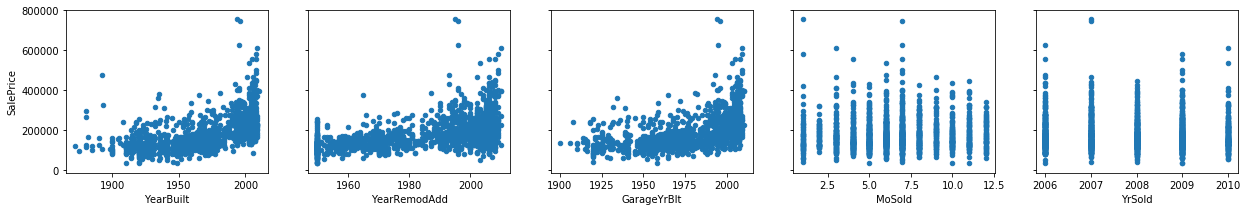

In [20]:
plot_scatter(train_dates)

In [21]:
class DatesAttributeTransform(BaseEstimator, TransformerMixin):
    def fit(self, data):
        return self
    def transform(self, data):
        remove_attribute = ['GarageYrBlt', 'MoSold', 'YrSold']
        for attribute in remove_attribute:
            data = data.drop(attribute, axis=1)
        return data

### 2.6 Sortable Categorical Features
* No feature presented a strong correlation with Sle Price
* Drop features for now 
* Might be worth considering Heating QC

In [22]:
class OrdinalAttributeConverter(BaseEstimator, TransformerMixin):
    def fit(self, data):
        return self
    def transform(self, data):
        data = data.dropna(subset=["BsmtExposure", "BsmtFinType1", "BsmtFinType2", "GarageFinish"])

        attribute_pave = ['Street', 'PavedDrive']
        for attribute in attribute_pave:
            data.loc[data[attribute] == 'Pave', attribute] = 2
            data.loc[data[attribute] == 'Grvl', attribute] = 0
            data.loc[data[attribute] == 'Y', attribute] = 2
            data.loc[data[attribute] == 'P', attribute] = 1
            data.loc[data[attribute] == 'N', attribute] = 0

        encoder = OrdinalEncoder(categories = [['IR3', 'IR2', 'IR1', 'Reg']])
        data[['LotShape']] = encoder.fit_transform(data[['LotShape']])

        encoder = OrdinalEncoder(categories = [['ELO', 'NoSeWa', 'NoSewr', 'AllPub']])
        data[['Utilities']] = encoder.fit_transform(data[['Utilities']])

        encoder = OrdinalEncoder(categories = [['Sev', 'Mod', 'Gtl']])
        data[['LandSlope']] = encoder.fit_transform(data[['LandSlope']])

        encoder = OrdinalEncoder(categories = [['NA', 'No', 'Mn', 'Av', 'Gd']])
        data[['BsmtExposure']] = encoder.fit_transform(data[['BsmtExposure']])

        encoder = OrdinalEncoder(categories = [['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']])
        data[['BsmtFinType1']] = encoder.fit_transform(data[['BsmtFinType1']])
        data[['BsmtFinType2']] = encoder.fit_transform(data[['BsmtFinType2']])

        encoder = OrdinalEncoder(categories = [['Po', 'Fa', 'TA', 'Gd', 'Ex']])
        data[['HeatingQC']] = encoder.fit_transform(data[['HeatingQC']])

        encoder = OrdinalEncoder(categories = [['N', 'Y']])
        data[['CentralAir']] = encoder.fit_transform(data[['CentralAir']])

        encoder = OrdinalEncoder(categories = [['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2',  'Min1', 'Typ']])
        data[['Functional']] = encoder.fit_transform(data[['Functional']])

        encoder = OrdinalEncoder(categories = [['NA', 'Unf', 'RFn', 'Fin']])
        data[['GarageFinish']] = encoder.fit_transform(data[['GarageFinish']])

        return data


In [23]:
train_ordinal = train[['Street', 'PavedDrive', 'LotShape', 'Utilities', 'LandSlope', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Functional', 'GarageFinish', 'SalePrice']]

ordinal_pipeline = Pipeline([
    ("ordinal_attribute_transformer", OrdinalAttributeConverter()),
])
train_ordinal = ordinal_pipeline.fit_transform(train_ordinal)

# Correlations matrix
corr_matrix = train_ordinal.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice       1.000000
GarageFinish    0.507940
HeatingQC       0.416296
BsmtExposure    0.362107
BsmtFinType1    0.266779
CentralAir      0.199528
PavedDrive      0.176576
Functional      0.090324
Street          0.042117
Utilities       0.017092
BsmtFinType2   -0.048386
LandSlope      -0.060509
LotShape       -0.258053
Name: SalePrice, dtype: float64

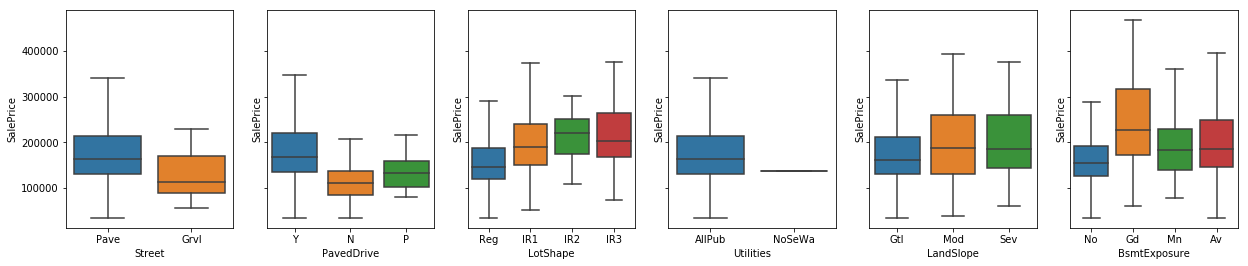

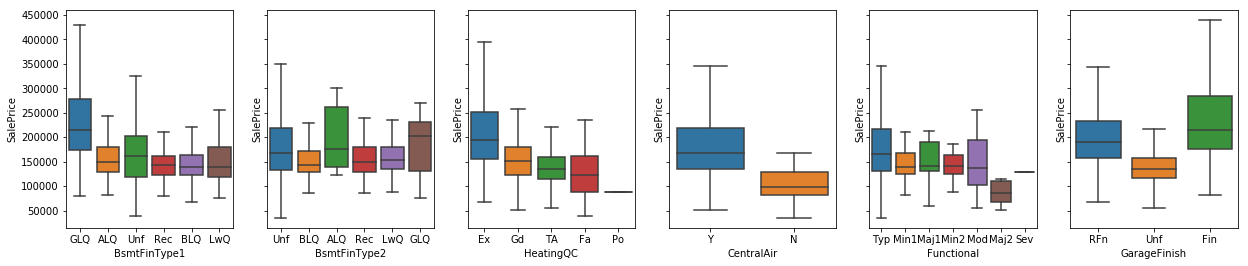

In [24]:
plot_boxplot(['Street', 'PavedDrive', 'LotShape', 'Utilities', 'LandSlope', 'BsmtExposure'], train)
plot_boxplot(['BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Functional', 'GarageFinish'], train)

In [25]:
class SortableCategoricalAttributeTransform(BaseEstimator, TransformerMixin):
    def fit(self, data):
        return self
    def transform(self, data):
        remove_attribute = ['Street', 'PavedDrive', 'LotShape', 'Utilities', 'LandSlope', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Functional', 'GarageFinish']
        for attribute in remove_attribute:
            data = data.drop(attribute, axis=1)
        return data

### 2.7 Non-Sortable Categorical Features
* Require one hot encoder
* Drop features without a clear correlation with Sale Price, i.e. features where difference between categories' median values is small and box range overlaps significantly between categories * Drop features with categories without a significant number of cases
* Relevance of features also considered


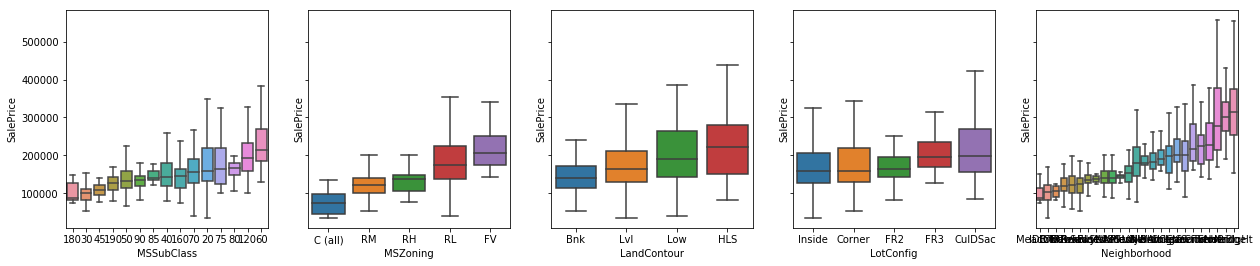

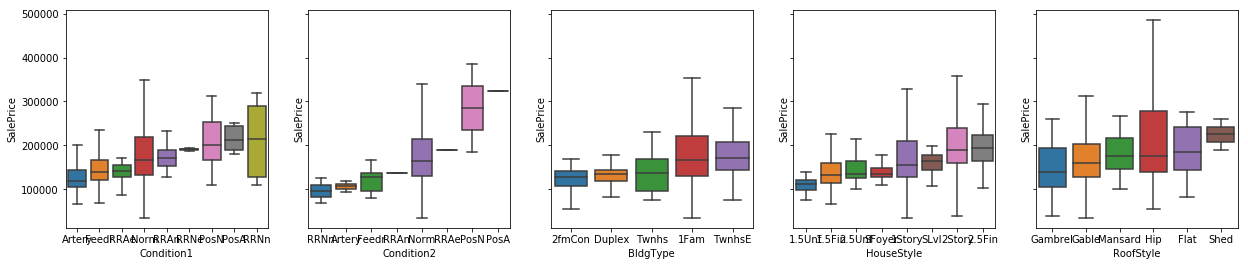

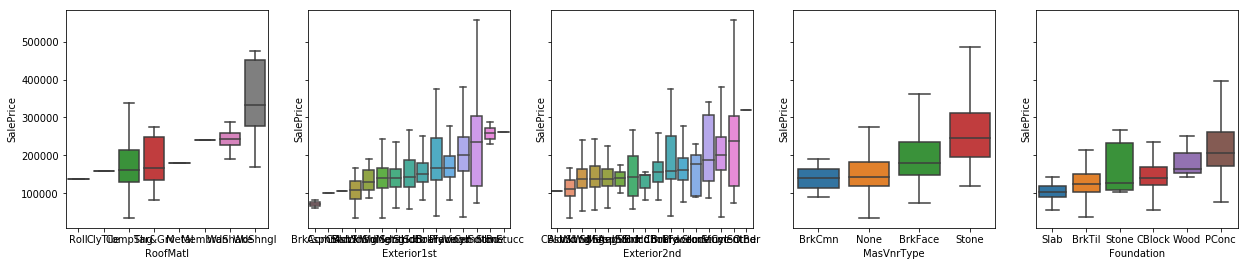

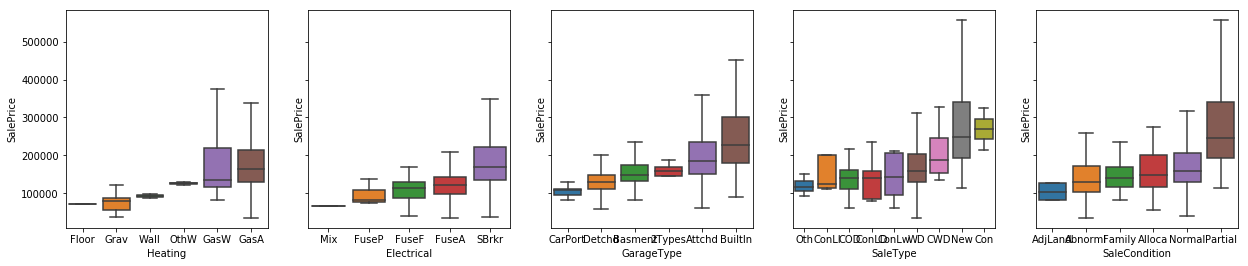

In [26]:
plot_boxplot(['MSSubClass', 'MSZoning', 'LandContour', 'LotConfig', 'Neighborhood'], train, True)
plot_boxplot(['Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle'], train, True)
plot_boxplot(['RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation'], train, True)
plot_boxplot(['Heating', 'Electrical', 'GarageType', 'SaleType', 'SaleCondition'], train, True)

In [27]:
train.groupby('SaleCondition').median()['SalePrice'].sort_values()

SaleCondition
AdjLand    104000.0
Abnorml    130000.0
Family     140500.0
Alloca     148145.0
Normal     160000.0
Partial    244600.0
Name: SalePrice, dtype: float64

In [28]:
train['MSZoning'].value_counts().index[0]

'RL'

In [29]:
class NonSortableCategoricalAttributeTransform(BaseEstimator, TransformerMixin):
    def __init__(self, replace_missing_value=False):
        self.replace_missing_value = replace_missing_value
    def fit(self, data):
        return self
    def transform(self, data):
        remove_attribute = ['MSSubClass', 'LotConfig', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation' , 'Heating', 'Electrical', 'GarageType', 'SaleType']
        for attribute in remove_attribute:
            data = data.drop(attribute, axis=1)

        if self.replace_missing_value:
            data[['MSZoning']] = data[['MSZoning']].fillna(data['MSZoning'].value_counts().index[0])

        encoder = OrdinalEncoder(categories = [['C (all)', 'RM', 'RH', 'RL', 'FV']])
        data[['MSZoning']] = encoder.fit_transform(data[['MSZoning']])

        encoder = OrdinalEncoder(categories = [['Bnk', 'Lvl', 'Low', 'HLS']])
        data[['LandContour']] = encoder.fit_transform(data[['LandContour']])

        encoder = OrdinalEncoder(categories = [['MeadowV', 'IDOTRR', 'BrDale', 'OldTown', 'Edwards', 'BrkSide', 'Sawyer', 'Blueste', 'SWISU', 'NAmes', 'NPkVill', 'Mitchel', 'SawyerW', 'Gilbert', 'NWAmes', 'Blmngtn', 'CollgCr', 'ClearCr', 'Crawfor', 'Veenker', 'Somerst', 'Timber', 'StoneBr', 'NoRidge', 'NridgHt']])
        data[['Neighborhood']] = encoder.fit_transform(data[['Neighborhood']])
        
        encoder = OrdinalEncoder(categories = [['AdjLand', 'Abnorml', 'Family', 'Alloca', 'Normal', 'Partial']])
        data[['SaleCondition']] = encoder.fit_transform(data[['SaleCondition']])

        return data

## 3. Train Model



In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

linear_reg = LinearRegression()
tree_reg = DecisionTreeRegressor()
florest_reg = RandomForestRegressor()

def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())

In [31]:
pipeline = Pipeline([
    ('missing_values_attribute_remover', MissingValuesAttributeRemove()),
    ('quality_attribute_transformer', QualityAttributeTransform()),
    ('condition_attribute_transform', ConditionAttributeTransform()),
    ('area_attribute_transform', AreaAttributeTransform()),
    ('rooms_attribute_transform', RoomsAttributeTransform()),
    ('dates_attribute_transform', DatesAttributeTransform()),
    ('sortable_categorical_attribute_transform', SortableCategoricalAttributeTransform()),
    ('non_sortable_categorical_attribute_transform', NonSortableCategoricalAttributeTransform()),
])
train_prepared = pipeline.fit_transform(train)
x_train_prepared = train_prepared.drop('SalePrice', axis=1)
y_train_prepared = train_prepared['SalePrice']

## 3.1 Linear Regression

In [32]:
linear_scores = cross_val_score(linear_reg, x_train_prepared, y_train_prepared, scoring='neg_mean_squared_error', cv=10)
display_scores(np.sqrt(-linear_scores))

Scores:  [27157.10587221 31318.15411154 27783.87332086 38035.45754493
 44542.70529976 33441.20847129 35581.3003182  30579.47663665
 58939.95800815 31282.95121761]
Mean:  35866.21908011936
Standard Deviation:  9105.823096632983


## 3.2 Decision Tree Regression
* Decision tree model performs worse than linear model due to overfitting

In [33]:
tree_scores = cross_val_score(tree_reg, x_train_prepared, y_train_prepared, scoring='neg_mean_squared_error', cv=10)
display_scores(np.sqrt(-tree_scores))

Scores:  [40845.71522925 41794.74696772 38384.32079416 37749.58367175
 34512.27066666 35857.94583253 35803.40212282 32044.70702656
 38268.12634932 36560.96010184]
Mean:  37182.17787626082
Standard Deviation:  2742.375182662506


## 3.3 Random Florest Regression
* Best performance

In [34]:
florest_scores = cross_val_score(florest_reg, x_train_prepared, y_train_prepared, scoring='neg_mean_squared_error', cv=10)
display_scores(np.sqrt(-florest_scores))

Scores:  [25591.68569459 28201.31102849 26417.17436597 33246.03992123
 32972.49093091 23335.54001073 26314.93091748 24145.92234695
 33991.68029324 29453.56717684]
Mean:  28367.03426864266
Standard Deviation:  3697.4173407264916


In [35]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'bootstrap': [True], 'n_estimators': [10, 30, 60], 'max_features': [2, 4, 6]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]
grid_search = GridSearchCV(florest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(x_train_prepared, y_train_prepared)
grid_search.best_params_

{'bootstrap': True, 'max_features': 4, 'n_estimators': 60}

In [36]:
final_model = grid_search.best_estimator_

## 4. Submit prediction

In [37]:
pipeline = Pipeline([
    ('missing_values_attribute_remover', MissingValuesAttributeRemove()),
    ('quality_attribute_transformer', QualityAttributeTransform()),
    ('condition_attribute_transform', ConditionAttributeTransform()),
    ('area_attribute_transform', AreaAttributeTransform()),
    ('rooms_attribute_transform', RoomsAttributeTransform()),
    ('dates_attribute_transform', DatesAttributeTransform()),
    ('sortable_categorical_attribute_transform', SortableCategoricalAttributeTransform()),
    ('non_sortable_categorical_attribute_transform', NonSortableCategoricalAttributeTransform(replace_missing_value=True)),
])
train_prepared = pipeline.fit_transform(train)
id = test.iloc[:,0]
test_prepared = pipeline.fit_transform(test)
test_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 10 columns):
Id               1459 non-null int64
MSZoning         1459 non-null float64
LandContour      1459 non-null float64
Neighborhood     1459 non-null float64
OverallQual      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
SaleCondition    1459 non-null float64
TotalArea        1459 non-null float64
TotRms           1459 non-null int64
dtypes: float64(5), int64(5)
memory usage: 114.1 KB


In [38]:
test_predict = final_model.predict(test_prepared)
predictions = np.column_stack((id, test_predict)).astype(int)
df = pd.DataFrame(data=predictions, columns=["Id","SalePrice"])
df.to_csv('submission.csv', index=False)